In [ ]:
!pip install pyunpack
!pip install patool
from pyunpack import Archive
Archive('/content/drive/MyDrive/CV/archive_flower.zip').extractall('/content/')

     |████████████████████████████████| 77 kB 3.2 MB/s 


In [ ]:
import numpy as np # this is for linear algebra
import pandas as pd # this is for data processing
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer
import cv2
from keras import regularizers, Model
from keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Activation, Flatten ,BatchNormalization
import pickle
from keras.models import Sequential
from sklearn.metrics import accuracy_score

tf.config.experimental.list_physical_devices('GPU') 
import os
for dirname, _, filenames in os.walk('/content/flowers'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [ ]:
# Check for available GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from PIL import Image        # for image processing
with tf.device('/GPU:0'):
    image_set = []
    label_set = []
    path = '/content/flowers'
    for flower_type in os.listdir(path):
        subpath = os.path.join(path, flower_type)
        for img in os.listdir(subpath):
            try:
                flower_pic = os.path.join(subpath,img)
                image = cv2.imread(flower_pic)
                image = cv2.resize(image, (224,224))
                image_set.append(image)
                label_set.append(flower_type)
            except Exception as e:    # To remove problematic pictures and prevent the program from encountering errors
                print(str(e))

In [ ]:
print(len(label_set))

4317


sunflower


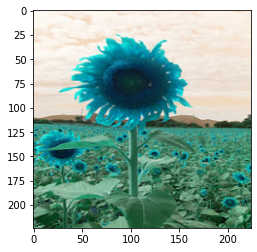

In [ ]:
print(label_set[2525])
plt.imshow(image_set[2525])

In [ ]:
image_set = np.array(image_set)
label_set = pd.Series(label_set)
image_set.shape

(4317, 224, 224, 3)

In [ ]:
label_set.shape

(4317,)

In [ ]:
label_set.head()

0    dandelion
1    dandelion
2    dandelion
3    dandelion
4    dandelion
dtype: object

In [ ]:
label_set.unique()

array(['dandelion', 'daisy', 'sunflower', 'rose', 'tulip'], dtype=object)

In [ ]:
label_set = label_set.map({'daisy':1, 'dandelion':2, 'rose':3, 'sunflower':4, 'tulip':5})
label_set.head()

0    2
1    2
2    2
3    2
4    2
dtype: int64

In [ ]:
label_set.unique()

array([2, 1, 4, 3, 5])

In [ ]:
label_set = pd.DataFrame(label_set) # to convert the shape (4323,) to (4323,1)
label_set.shape

(4317, 1)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_set, label_set, test_size=0.2, random_state=37)
print("Length of x_train: ", len(x_train)) 
print("Length of y_train: ", len(y_train))
print("Length of x_test: ", len(x_test))
print("Length of y_test: ", len(y_test))

Length of x_train:  3453
Length of y_train:  3453
Length of x_test:  864
Length of y_test:  864


In [ ]:
#One vs all classification
label_binrizer = LabelBinarizer()
y_train = label_binrizer.fit_transform(y_train)

In [ ]:
image_set[0].shape

(224, 224, 3)

In [ ]:
def create_model(images, labels ):
  with tf.device(device_name):
        class myCallback(tf.keras.callbacks.Callback):        # interrupts the training when 99.9% is achieved
            def on_epoch_end(self, epoch, logs={}):
                if(float(logs.get('accuracy'))>0.98):
                    print("\nReached 99.9% accuracy so cancelling training!")
                    self.model.stop_training = True
  callbacks = myCallback()
  weight_decay = 0.0005
  layers=[Conv2D(filters=64,kernel_size=[3,3],padding='same',activation='relu',name="conv1_1"),
  Conv2D(filters=64,kernel_size=[3,3],padding='same',activation='relu',name="conv1_2"),
  MaxPooling2D(pool_size=(2, 2)),

  Conv2D(filters=128,kernel_size=[3,3],padding='same',activation='relu',name="conv2_1"),
  Conv2D(filters=128,kernel_size=[3,3],padding='same',activation='relu',name="conv2_2"),
  MaxPooling2D(pool_size=(2, 2)),

  Conv2D(filters=256,kernel_size=[3,3],padding='same',activation='relu',name="conv3_1"),
  Conv2D(filters=256,kernel_size=[3,3],padding='same',activation='relu',name="conv3_2"),
  Conv2D(filters=256,kernel_size=[3,3],padding='same',activation='relu',name="conv3_3"),
  MaxPooling2D(pool_size=(2, 2)),

  Conv2D(filters=512,kernel_size=[3,3],padding='same',activation='relu',name="conv4_1"),
  Conv2D(filters=512,kernel_size=[3,3],padding='same',activation='relu',name="conv4_2"),
  Conv2D(filters=512,kernel_size=[3,3],padding='same',activation='relu',name="conv4_3"),
  MaxPooling2D(pool_size=(2, 2)),

  Conv2D(filters=512,kernel_size=[3,3],padding='same',activation='relu',name="conv5_1"),
  Conv2D(filters=512,kernel_size=[3,3],padding='same',activation='relu',name="conv5_2"),
  Conv2D(filters=512,kernel_size=[3,3],padding='same',activation='relu',name="conv5_3"),
  MaxPooling2D(pool_size=(2, 2)),
  Flatten(),

  Dense(4096,activation='relu', kernel_regularizer=regularizers.l2(weight_decay)), 
  Dropout(0.5),
  Dense(4096,activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
  Dropout(0.5),
  Dense(5,activation=None),

  Activation('softmax')]
  model=Sequential(layers)
  model.compile(keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
  hist = model.fit(images, labels,epochs=30, callbacks=[callbacks])
  return model

In [ ]:
x_train = x_train/255
x_test = x_test/255

In [ ]:
model = create_model(x_train, y_train)

Epoch 1/30
108/108 [==============================] - 144s 949ms/step - loss: 4.6815 - accuracy: 0.2896
Epoch 2/30
108/108 [==============================] - 90s 832ms/step - loss: 2.5317 - accuracy: 0.4054
Epoch 3/30
108/108 [==============================] - 90s 831ms/step - loss: 2.0195 - accuracy: 0.4179
Epoch 4/30
108/108 [==============================] - 90s 831ms/step - loss: 1.7834 - accuracy: 0.4364
Epoch 5/30
108/108 [==============================] - 90s 832ms/step - loss: 1.6150 - accuracy: 0.4752
Epoch 6/30
108/108 [==============================] - 90s 831ms/step - loss: 1.4791 - accuracy: 0.5201
Epoch 7/30
108/108 [==============================] - 90s 831ms/step - loss: 1.3763 - accuracy: 0.5783
Epoch 8/30
108/108 [==============================] - 90s 832ms/step - loss: 1.2859 - accuracy: 0.5905
Epoch 9/30
108/108 [==============================] - 90s 833ms/step - loss: 1.1944 - accuracy: 0.6305
Epoch 10/30
108/108 [==============================] - 90s 833ms/step - 

In [ ]:
model.save('/content/drive/MyDrive/CV/vgg16_30_2.h5')

In [ ]:
model=keras.models.load_model("/content/drive/MyDrive/CV/vgg16_30_2.h5")

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)      

In [ ]:
y_pred = model.predict(x_test)
# One vs all classification
y_test = label_binrizer.fit_transform(y_test)

In [ ]:
print('VGG16 test accuracy: ',accuracy_score(y_test, y_pred.round()))

VGG16 test accuracy:  0.6932870370370371


In [ ]:
data=[list(ele) for ele in y_pred]
data_y=[list(ele) for ele in y_test]
data_y=[ele.index(max(ele))+1 for ele in data_y]
data=[ele.index(max(ele))+1 for ele in data]

In [ ]:
count=0
sz=len(data)
for i in range(sz):
  if data[i] == data_y[i]:
    count+=1
print(count/sz)

0.6956018518518519
